In [82]:
import elevation_grid as eg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import geopandas 


import sys
import datetime
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('weather_tomorrow').getOrCreate()
assert spark.version >= '2.3' # make sure we have Spark 2.3+
spark.sparkContext.setLogLevel('WARN')

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator

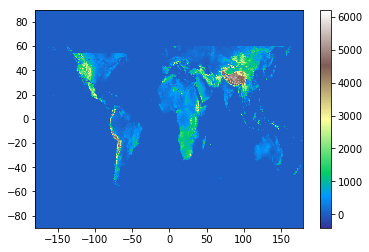

In [56]:
lats, lons = np.meshgrid(np.arange(-90,90,.5),np.arange(-180,180,.5))
elevs = [eg.get_elevations(np.array([late,lone]).T) for late,lone in zip(lats,lons)]
plt.pcolormesh(lons,lats,elevs,cmap='terrain')
plt.colorbar()

In [5]:
lats = list(np.arange(-90,90,.5))
lons = list(np.arange(-180,180,.5))
new_1 = []
new_2 = []

In [6]:
for i in lats:
    for j in lons:
        new_1.append(i)
        new_2.append(j)
    

In [7]:
df = pd.DataFrame(list(zip(new_1,new_2)), columns =['latitude', 'longitude'])

In [8]:
df['elevation'] = df.apply(lambda x: eg.get_elevation(x.latitude,x.longitude),axis=1)

In [9]:
df['tmax'] = 12.0

In [10]:
df['date'] = datetime.date(year=2019, month=11, day=8)

In [11]:
df = df[['date','latitude','longitude','elevation','tmax']]

In [12]:
tmax_schema = types.StructType([
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])
nov_09=spark.createDataFrame(df, schema=tmax_schema)

/Users/zhixuanchi/Desktop/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [28]:
model = PipelineModel.load('./weather-model_retrain')
prediction = model.transform(nov_09)


In [29]:
prediction = prediction.select(prediction['latitude'],prediction['longitude'], prediction['elevation'],prediction['prediction'])

In [30]:
# set the configuration for arrwo
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# convert the spark df to pandas df so that we can plot
prediction_pd = prediction.select("*").toPandas()

In [32]:
# def get_pred(lat,lon,ele):
#     pred = prediction_pd[(prediction_pd['latitude']==lat) & (prediction_pd['longitude']==lon) & (prediction_pd['elevation']==ele)]['prediction']
#     return pred

In [49]:
def get_preds(latloneles):
    preds = []
    for lat, lon, ele in latloneles:
        pred = prediction_pd[(prediction_pd['latitude']==lat) & (prediction_pd['longitude']==lon) & (prediction_pd['elevation']==ele)]['prediction']
        preds.append(pred)
    return preds

In [73]:
lats, lons = np.meshgrid(np.arange(-90,90,.5),np.arange(-180,180,.5))
# eles is a 720*360 2d array/list or say a grid
eles = [eg.get_elevations(np.array([lat,lon]).T) for lat,lon in zip(lats,lons)]

# create a 720*360 2d list to store the predicted temps
temps = [[0 for i in range(360)] for j in range(720)]

# define a functino to put the prediction from pandas dataframe to the 2d array we created
def get_temp(x):
    x_coordin = int((x.longitude-(-180))*2)
    y_coordin = int(((x.latitude)-(-90))*2)
    temps[x_coordin][y_coordin]=x.prediction

prediction_pd.apply(get_temp, axis=1)


0         None
1         None
2         None
3         None
4         None
          ... 
259195    None
259196    None
259197    None
259198    None
259199    None
Length: 259200, dtype: object

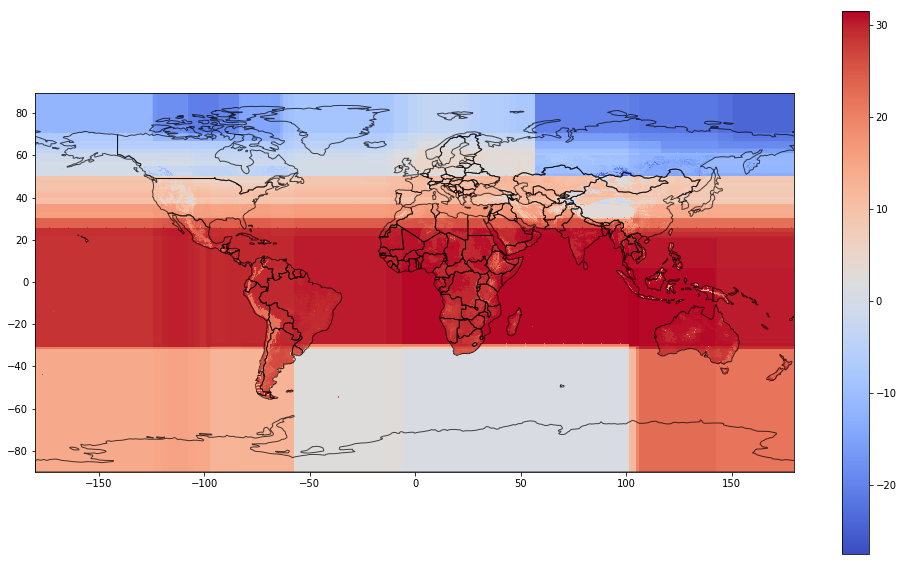

In [124]:
fig, ax = plt.subplots(figsize=(17,10))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
plt.pcolormesh(lons,lats,temps,cmap='coolwarm')
world.plot(ax=ax, color='none', edgecolor='black',alpha=0.7)
plt.colorbar()
# Since our longitude's upper bound is 179.5, therefore will be white strip in the plot
plt.xlim(-180,179.5)
plt.show()

In [85]:
(prediction_pd).describe()

latitude      longitude      elevation     prediction
count  259200.000000  259200.000000  259200.000000  259200.000000
mean       -0.250000      -0.250000     120.035866      12.399724
std        51.960289     103.919899     450.186768      15.909960
min       -90.000000    -180.000000    -415.000000     -27.589941
25%       -45.125000     -90.125000       0.000000       1.055519
50%        -0.250000      -0.250000       0.000000      14.332498
75%        44.625000      89.625000       0.000000      28.950534
max        89.500000     179.500000    6205.000000      31.610615

latitude  longitude  elevation  prediction
0          -90.0     -180.0        0.0   14.332498
1          -90.0     -179.5        0.0   14.332498
2          -90.0     -179.0        0.0   14.332498
3          -90.0     -178.5        0.0   14.332498
4          -90.0     -178.0        0.0   14.332498
...          ...        ...        ...         ...
259195      89.5      177.5        0.0  -23.999681
259196      89.5      178.0        0.0  -23.999681
259197      89.5      178.5        0.0  -23.999681
259198      89.5      179.0        0.0  -23.999681
259199      89.5      179.5        0.0  -23.999681

[259200 rows x 4 columns]

In [71]:
print(type(prediction_pd))

<class 'pandas.core.frame.DataFrame'>


[[14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.332498031904832,
  14.33249